# Практическое задание №6 "Градиентный бустинг. AdaBoost".

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. 

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn import model_selection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Задание №1

__Методы__

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [4]:
def bias(y, z):
    return (y - z)

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [6]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    
    train_mse = mean_squared_error(y_train, train_prediction)
    test_mse = mean_squared_error(y_test, test_prediction)
    return [train_mse, test_mse]

__Датасет, обучение, визуализация__

In [7]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

* Зависимость только от количества деревьев (количество итераций в алгоритме)

In [8]:
mse = []
n_trees_list = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40]
max_depth = 3
eta = 0.1
for n_trees in n_trees_list:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_i = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    mse.append(mse_i)
mse = np.array(mse).T
var1_mse = mse
var1_x = n_trees_list

* Зависимость только от глубины деревьев

In [9]:
mse = []
n_trees = 15
max_depth_list = [1, 2, 3, 4, 5, 6, 7, 10, 12, 15]
eta = 0.1
for max_depth in max_depth_list:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_i = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    mse.append(mse_i)
mse = np.array(mse).T
var2_mse = mse
var2_x = max_depth_list

* Тепловая карта с разным набором гиперпараметров (обучение ~7 минут на моей машине)

In [10]:
%%time
mse = []
n_trees_list = [3, 5, 7, 10, 15, 20, 30, 40]
max_depth_list = [2, 3, 4, 5, 6, 7, 10, 15]
eta = 0.1
for i in range(len(n_trees_list)):
    for j in range(len(max_depth_list)):
        n_trees = n_trees_list[i]
        max_depth = max_depth_list[j]
        coefs = [1] * n_trees
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        mse_i = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
        row = [n_trees, max_depth, mse_i[0], mse_i[1]]
        mse.append(row)
var1_mse_df = pd.DataFrame(mse, columns=['n_trees', 'max_depth', 'train_mse', 'test_mse'])
var3_hm_train = var1_mse_df.pivot(index='n_trees', columns='max_depth', values='train_mse')
var3_hm_test = var1_mse_df.pivot(index='n_trees', columns='max_depth', values='test_mse')

Wall time: 6min 45s


Визуализация

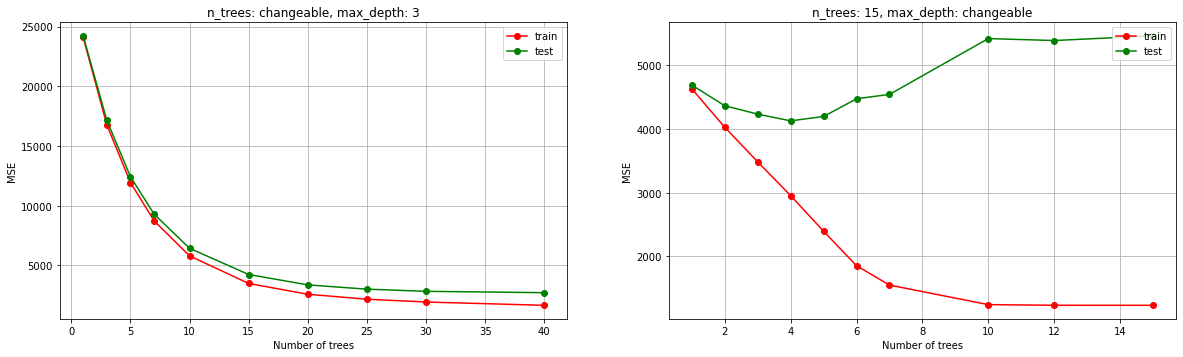

In [11]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
plt.plot(var1_x, var1_mse[0], color='r', label='train', marker='o')
plt.plot(var1_x, var1_mse[1], color='g', label='test', marker='o')
plt.title(f'n_trees: changeable, max_depth: 3')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(var2_x, var2_mse[0], color='r', label='train', marker='o')
plt.plot(var2_x, var2_mse[1], color='g', label='test', marker='o')
plt.title(f'n_trees: 15, max_depth: changeable')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid()

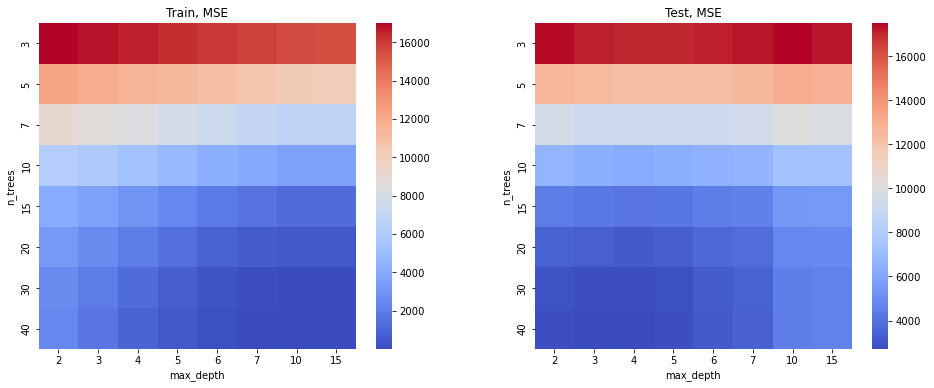

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

fig.set_size_inches(16, 6)
fig.subplots_adjust(wspace=0.25)
sns.heatmap(var3_hm_train, ax=ax1, cmap='coolwarm')
sns.heatmap(var3_hm_test, ax=ax2, cmap='coolwarm')
ax1.set_title('Train, MSE')
ax2.set_title('Test, MSE')
plt.show()

__Вывод:__

* При фиксированном количестве деревьев и растущем количестве максимальной глубины - быстрое переобучение ансамбля, рост ошибки при глубине > 4.
* При фиксированной максимальной глубине и растущем количестве деревьев - переобучение не наблюдается, значение ошибки уменьшается, но время обработки данных сильно увеличивается.
* По результатам тепловой карты видно, что алгоритм минимизирует MSE на тренировочной выборке при максимально возможных гиперпараметрах *n_trees*, _max_depth_. На тестовой выборке алгоритм также больше любит большое количество деревьев, однако параметр _max_depth_ увеличивать сильно нельзя, иначе будет расти MSE (переобучение).

## Задание №2

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

__Методы__

In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [14]:
# Случайное подмножество
def get_subsample(len_sample, fraction):
    # будем сохранять не сами признаки, а их индексы, для экономии памяти
    sample_indexes = [i for i in range(len_sample)]
    np.random.shuffle(sample_indexes)
    limit = int(len_sample * fraction)
    return sample_indexes[:limit]

In [15]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # создаем случайную подвыборку, на которой будем обучать новый базовый алгоритм.
        # по заданию он подвыборка составляет 0.5 от всей тренировочной.
        subsample = get_subsample(X_train.shape[0], 0.5)
        X_train_sub = X_train[subsample, :]
        y_train_sub = y_train[subsample]
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_sub, y_train_sub)
            
            train_errors.append(mean_squared_error(y_train_sub, gb_predict(X_train_sub, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_sub, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_sub, bias(y_train_sub, target))
            
            train_errors.append(mean_squared_error(y_train_sub, gb_predict(X_train_sub, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

__Датасет, обучение стохастического градиентого бустинга и обычного бустинга, сравнение__

* SGBM

In [16]:
mse = []
n_trees_list = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40]
max_depth = 3
eta = 0.1
for n_trees in n_trees_list:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_i = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    mse.append(mse_i)
mse = np.array(mse).T
sgbm_mse = mse
sgbm_x = n_trees_list

* GBM

Уже посчитали в Задании 1.

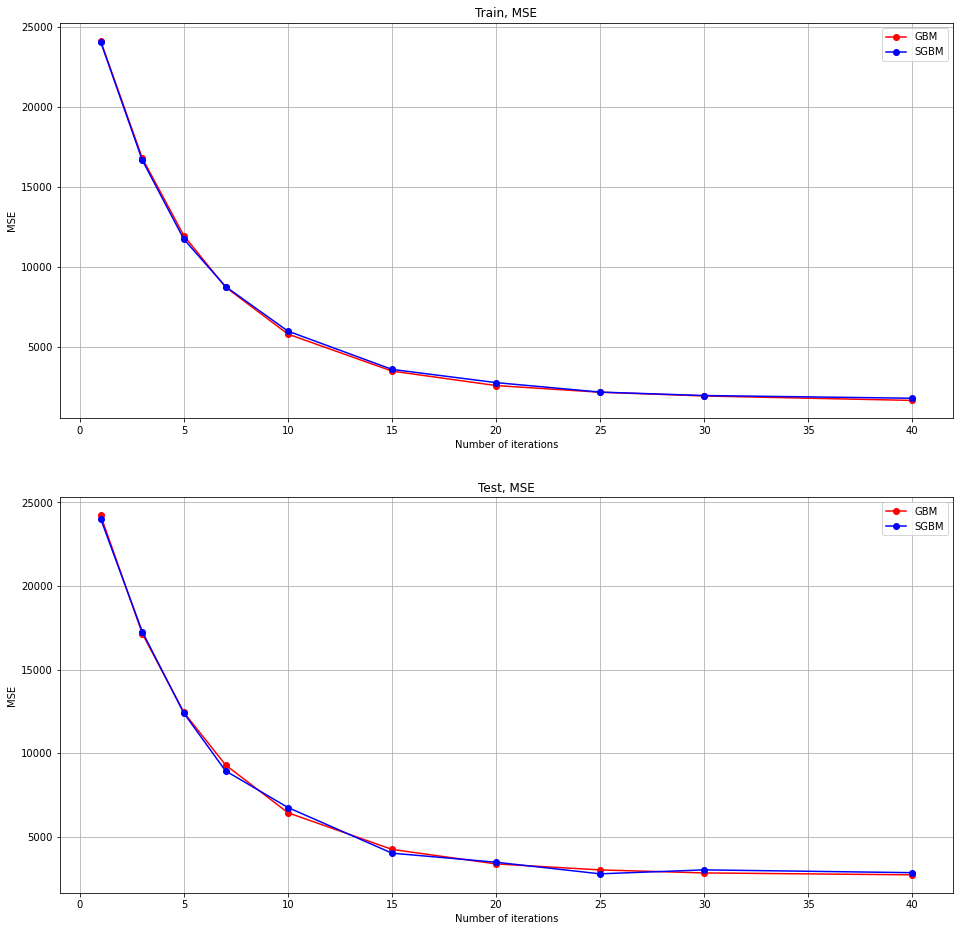

In [24]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(var1_x, var1_mse[0], color='r', label='GBM', marker='o')
plt.plot(sgbm_x, sgbm_mse[0], color='b', label='SGBM', marker='o')
plt.title(f'Train, MSE')
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(var1_x, var1_mse[1], color='r', label='GBM', marker='o')
plt.plot(sgbm_x, sgbm_mse[1], color='b', label='SGBM', marker='o')
plt.title(f'Test, MSE')
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid()

__Вывод:__ Из графиков видно, что значение ошибки MSE при одинаковых гиперпараметрах почти не отличается. Однако, в методе SGBM используется меньше ресурсов, обучение происходит быстрее. Получается, что SGBM выгоднее чем обычный GBM.

---